<a href="https://colab.research.google.com/github/yasuhiroinoue/AppMathSci/blob/main/EVT_tutorial_en.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


# Extreme Value Theory Tutorial (Fixed Version)

This Colab‑ready notebook demonstrates **Extreme Value Theory (EVT)** on two open datasets:

* **Tokyo daily precipitation** (Open‑Meteo, 1950‑2024)  
* **S&P 500 daily log‑returns** (Yahoo Finance, 1950‑2024)

Techniques:

| Section | Method | Distribution |
|---------|--------|--------------|
| 4 | Block‑Maxima | Generalized Extreme Value (GEV) |
| 5 | Peaks‑Over‑Threshold | Generalized Pareto (GP) |
| 6 | Return‑level estimation (GEV & GP) |
| 7 | Bootstrap uncertainty |
| 8‑B | Non‑stationary GEV (μ = β₀ + β₁·year) |


## 講義イントロダクション（院生向け）

**学習目標**
- 極値統計学 (Extreme Value Theory; EVT) の基本概念と工学分野での役割を理解する。
- ブロック最大値法と閾値超過法の違いを説明し、適切なモデル（GEV/GPD）を選択できるようにする。
- Python を用いたデータ取得・フィッティング・再現期間計算の実装を再現し、結果を批判的に解釈できるようにする。

**受講前提**
- 基礎的な確率論・統計推測（最尤推定、信頼区間）の知識。
- Python によるデータ解析経験（pandas・NumPy・Matplotlib の基礎）。

**このノートの進め方**
1. まず理論解説セルで背景と数式を確認する。
2. 続いてコードセルを実行し、出力の意味や前処理の意図を解説セルで理解する。
3. 各セクション末尾のチェックポイントで重要概念を整理し、追加課題で応用力を養う。

データセットは Open-Meteo の東京日降水量（1950-2024）と Yahoo Finance の S&P 500 日次リターンを用いる。降雨量は土木・都市防災、株価リターンは金融工学の極値リスク評価を想定した教材である。


In [1]:

# 1️⃣ Install libraries not pre‑installed in Colab
!pip -q install yfinance evmodels


ERROR: Could not find a version that satisfies the requirement evmodels (from versions: none)
ERROR: No matching distribution found for evmodels


### 実行環境メモ
- Google Colab では `!pip install` で追加ライブラリを導入できるが、学内サーバやローカル環境では事前に `pip install yfinance evmodels` を実行しておく。
- ネットワークに接続できない環境では Open-Meteo API や Yahoo Finance からデータを取得できないため、事前に CSV をダウンロードし `pd.read_csv` で読み込む代替案を用意する。
- 解析時に再現性を確保するため、ライブラリのバージョンと取得日時を研究ノートに記録しておくこと。


## 2‑A  Tokyo daily precipitation (Open‑Meteo)

### 理論解説：降雨量データと極値解析の文脈
- 土木・防災分野では「再現期間 T 年」の設計降雨量が重要であり、長期観測データから極値分布を推定してインフラ設計に反映する。
- 日降水量系列は季節性や年々変動を持つため、まずは観測地点を固定し、ブロック化や閾値選択の前提となる独立性・定常性を概観する。
- Open-Meteo のアーカイブ API は再現可能なデータ取得手段であり、データ取得プロセス自体を記録しておくことで研究の透明性を確保できる。


In [2]:

import requests, pandas as pd, numpy as np, matplotlib.pyplot as plt

lat, lon = 35.68, 139.76  # Central Tokyo
url = (
    "https://archive-api.open-meteo.com/v1/archive?"
    f"latitude={lat}&longitude={lon}&daily=precipitation_sum"
    "&start_date=1950-01-01&end_date=2024-12-31&timezone=Asia/Tokyo"
)
data = requests.get(url, timeout=30).json()
tokyo = pd.DataFrame({
    "date": pd.to_datetime(data["daily"]["time"]),
    "precip": data["daily"]["precipitation_sum"]
}).set_index("date")
tokyo.head()


,precip
date,
1950-01-01,2.4
1950-01-02,1.5
1950-01-03,9.4
1950-01-04,0.0
1950-01-05,0.5


### コード解説：Open-Meteo からのデータ取得
1. `requests` で REST API を叩き、日別降水量 `precipitation_sum` を JSON 形式で取得する。
2. `pandas.DataFrame` に整形し、`date` を日時インデックスに設定することで、後続のリサンプリング（年最大値など）が容易になる。
3. レスポンスの欠測値や API エラーを検知するため、実務では `status_code` の確認や `try-except` を追加する。

**チェックポイント**
- 期間 1950-2024 年という長系列は気候変動による非定常性を含む可能性がある。
- 気象庁など公式データとの差異を検証し、品質管理を行う。


## 2‑B  S&P 500 daily log‑returns (Yahoo Finance)

### 理論解説：金融リターン系列と極値
- 株価水準よりも対数リターンを解析対象とすることで、時間軸に対して加法的な性質と対数正規仮定の近似が得られる。
- 金融リターンは自己相関が小さいと仮定される一方、厚い裾を持つため極値解析の対象となる。
- 本教材では降雨量と対照させる目的でリターン系列を紹介するが、以降の理論展開は気象データに焦点を当てる。


In [3]:

import yfinance as yf, numpy as np
sp = yf.download("^GSPC", start="1950-01-03", auto_adjust=True, progress=False)
sp["logret"] = np.log(sp["Close"]).diff().dropna()
sp = sp.dropna()
sp.head()


Price,Close,High,Low,Open,Volume,logret
Ticker,^GSPC,^GSPC,^GSPC,^GSPC,^GSPC,
Date,,,,,,
1950-01-04,16.850000,16.850000,16.850000,16.850000,1890000,0.011340
1950-01-05,16.930000,16.930000,16.930000,16.930000,2550000,0.004737
1950-01-06,16.980000,16.980000,16.980000,16.980000,2010000,0.002949
1950-01-09,17.080000,17.080000,17.080000,17.080000,2520000,0.005872
1950-01-10,17.030001,17.030001,17.030001,17.030001,2160000,-0.002932


### コード解説：Yahoo Finance からのリターン算出
1. `yfinance.download` で S&P 500 指数を取得し、株式分割等を考慮するため `auto_adjust=True` を利用する。
2. `np.log` の差分で `logret` 列を作成し、`dropna()` で初期の欠測を除去する。
3. 金融データは取引休場日があるため、欠損日付を補完する場合は市場カレンダーを参照する。

**ディスカッション**
- どの程度の期間を対象にするかで、極値推定結果（特に裾の厚さ）が変わりうる。


## 3  Exploratory Data Analysis

### 理論解説：探索的データ解析 (EDA)
- 極値解析の前に時系列全体の傾向・季節性・外れ値を把握して前処理方針を決める。
- ブロック最大値法ではブロック内の独立性が重要なため、強い自己相関が見られる場合はデトレンドや季節調整を検討する。
- 降水量データはゼロが多い離散的な分布であることに留意し、不要なゼロを取り除く閾値処理を行うかどうか考える。


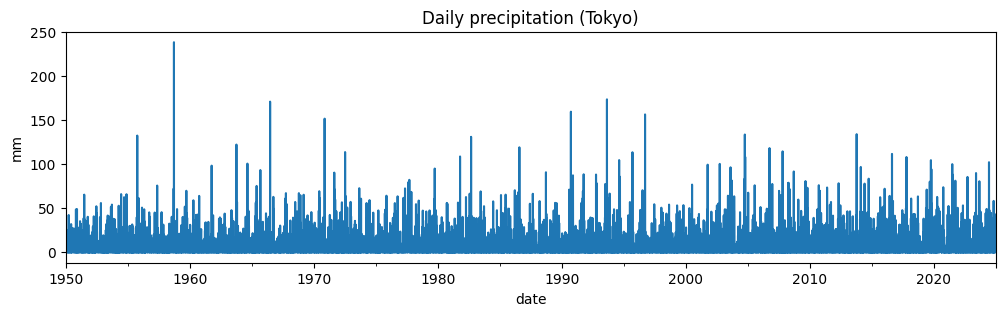

In [4]:

tokyo["precip"].plot(figsize=(12,3), title="Daily precipitation (Tokyo)")
plt.ylabel("mm");

# sp["logret"].hist(bins=100, figsize=(6,3))
# plt.title("Daily log returns (S&P 500)");


### コード解説：可視化のポイント
- `resample` 前の生データを可視化し、長期トレンドや観測の欠測を目視確認する。
- 同様に株価リターンのヒストグラムを描けば厚い裾（レヴィ過程に近い振る舞い）を確認できる。
- グラフの縦軸単位（mm）や期間を明示し、図表番号を付けて講義資料に転記しやすくする。


## 4  Block‑Maxima → GEV

### 理論解説：ブロック最大値法と GEV 分布
- Fisher–Tippett–Gnedenko の極限定理により、独立同分布な系列の最大値の極限分布は GEV（Generalized Extreme Value）に収束する。
- GEV のパラメータは形状 ξ (xi)、位置 μ (mu)、尺度 σ (sigma) であり、ξ の符号により Gumbel/Fréchet/Weibull 型に分類される。
- 年最大値（Yearly Block）を用いる場合、季節変化を持つ日降水量を 1 年単位で最大化することでブロック内の依存を緩和する。
- モデル適合度は QQ プロットや Kolmogorov–Smirnov 検定、AIC などで評価する。


GEV parameters  xi=0.185,  mu=73.5,  sigma=22.1


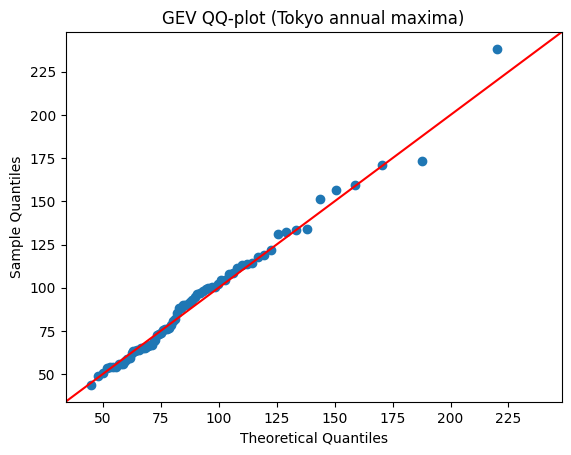

In [5]:

from scipy.stats import genextreme
import statsmodels.api as sm

annual_max = tokyo["precip"].resample("YE").max().dropna()
c, loc, scale = genextreme.fit(annual_max)  # SciPy: shape = -xi
xi = -c
print(f"GEV parameters  xi={xi:.3f},  mu={loc:.1f},  sigma={scale:.1f}")

sm.ProbPlot(annual_max, genextreme, distargs=(c,), loc=loc, scale=scale).qqplot(line="45")
plt.title("GEV QQ‑plot (Tokyo annual maxima)");


### コード解説：GEV フィッティング
1. `resample("YE").max()` で毎年の最大降水量を計算し、`dropna()` で欠測年を除外する。
2. `genextreme.fit` は SciPy の最尤推定であり、SciPy のパラメータ化では形状 `c = -ξ` に注意する。
3. 推定結果を QQ プロットで可視化し、直線からの逸脱が小さいほどモデル適合が良い。

**チェックポイント**
- 年ブロックでは季節変化を平均化するが、短期的な依存が残る可能性がある。
- 代替として月ブロック・季節ブロック等を検討し、設計目的に応じて比較する。


## 5  Peaks‑Over‑Threshold → GP (with custom Mean Residual Life)

### 理論解説：閾値超過法 (POT) と Generalized Pareto
- Pickands–Balkema–de Haan 定理により、高い閾値を超える超過量は GP (Generalized Pareto) 分布で近似できる。
- 閾値 `u` は高すぎても低すぎても推定が不安定になるため、Mean Residual Life (MRL) プロット等で妥当性を判断する。
- POT 法は限られた上位データのみを利用するため、データ効率が高く、頻度の小さい極端事象でも推定が可能。


GP parameters  xi=0.148,  sigma=14.1,  threshold u=20.8 mm


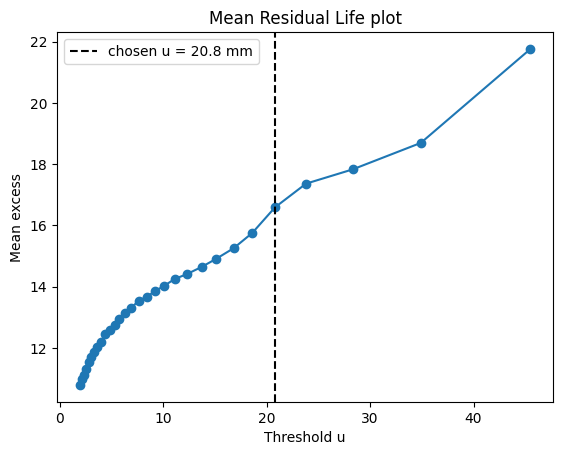

In [6]:

from scipy.stats import genpareto

# Threshold u = 95th percentile
u = tokyo["precip"].quantile(0.95)

# Excesses above u
exceed = tokyo["precip"][tokyo["precip"] > u] - u

# Fit GP (location fixed at 0)
xi_gp, loc_gp, sigma_gp = genpareto.fit(exceed, floc=0)
print(f"GP parameters  xi={xi_gp:.3f},  sigma={sigma_gp:.1f},  threshold u={u:.1f} mm")

# Mean Residual Life plot
def mean_residual_life(x, thresholds):
    mrl = []
    for thr in thresholds:
        exc = x[x > thr] - thr
        mrl.append(exc.mean() if exc.size else np.nan)
    return thresholds, np.array(mrl)

u_grid = np.quantile(tokyo["precip"], np.linspace(0.70, 0.99, 30))
u_vals, mrl_vals = mean_residual_life(tokyo["precip"].values, u_grid)

plt.plot(u_vals, mrl_vals, "o-")
plt.axvline(u, color="k", ls="--", label=f"chosen u = {u:.1f} mm")
plt.xlabel("Threshold u"); plt.ylabel("Mean excess")
plt.title("Mean Residual Life plot")
plt.legend();


### コード解説：閾値選択と GP フィット
1. `quantile(0.95)` を初期閾値とし、`tokyo["precip"] > u` で超過データを抽出する。
2. `genpareto.fit` で閾値超過量 (`exceed`) に対して最尤推定を行い、位置パラメータは 0 に固定する。
3. MRL プロットを自作し、閾値付近で平均超過量がほぼ線形になっているか確認する。

**チェックポイント**
- 閾値は固定値ではなく、感度分析で複数候補を比較する。
- 降水量のようにゼロが多い系列では、事前に無降雨日の扱いを定義しておく。


## 6  Return Levels (corrected GP calculation)

### 理論解説：再現期間とリターンレベル
- リターンレベル z_T は「平均 T 年に 1 回超える強度」であり、GEV では分位点、GP では超過率と組み合わせて求める。
- 設計基準では 50 年・100 年といった長い再現期間が求められるが、観測期間より長い外挿になるため不確実性に注意する。
- GEV と GP の結果を比較し、一貫性があるかを確認することでモデルの信頼性を高める。


In [7]:

# Return level from stationary GEV
def gev_rl(T):
    p = 1 / T
    return genextreme.ppf(1 - p, c, loc=loc, scale=scale)

# Exceedance rate per *year*
lambda_u_year = exceed.size / len(tokyo) * 365.25  # len(tokyo) is number of days

def gp_rl(T):
    # Poisson‑GP formula with yearly rate
    return u + (sigma_gp / xi_gp) * ((T * lambda_u_year) ** xi_gp - 1)

for T in [10, 20, 50, 100]:
    print(f"{T:>3}‑year RL  |  GEV {gev_rl(T):6.1f} mm   GP {gp_rl(T):6.1f} mm")


 10‑year RL  |  GEV  135.2 mm   GP  131.5 mm
 20‑year RL  |  GEV  161.0 mm   GP  153.8 mm
 50‑year RL  |  GEV  199.9 mm   GP  187.0 mm
100‑year RL  |  GEV  233.8 mm   GP  215.3 mm


### コード解説：GEV・GP によるリターンレベル計算
1. `genextreme.ppf` で GEV の分位点を直接計算し、関数 `gp_rl` で Poisson 仮定に基づく GP の再現期間計算を実装する。
2. `lambda_u_year` で年間超過回数を推定し、`u + (sigma_gp / xi_gp) * ((T * lambda_u_year) ** xi_gp - 1)` の形で再現レベルを計算している。
3. 10・20・50・100 年と複数の再現期間を比較し、GEV/POT の整合性を示す。

**チェックポイント**
- `xi_gp` が 0 に近い場合、数値的に不安定になるためロピタルの極限形（対数型）を用意すると堅牢になる。
- 実務では信頼区間や感度分析を提示し、単一推定値に依存しない意思決定を行う。


## 7  Bootstrap Confidence Interval (50‑year RL)

### 理論解説：ブートストラップによる不確実性評価
- EVT 推定量はサンプルサイズが小さい場合にばらつきが大きいため、非パラメトリック・ブートストラップで分布を近似する。
- ブロック最大値の再標本化では「年」を単位とした再抽出を行い、ブロック依存構造を保持する。
- 得られた信頼区間は再現期間の設計値に対する不確実性を関係者に可視化するのに有用。


In [8]:

import numpy as np
N_bs = 500
rng = np.random.default_rng(0)
rl50 = []
for _ in range(N_bs):
    samp = rng.choice(annual_max, size=len(annual_max), replace=True)
    cb, locb, scaleb = genextreme.fit(samp)
    rl50.append(genextreme.ppf(1-1/50, cb, locb, scaleb))
ci_low, ci_high = np.percentile(rl50, [2.5, 97.5])
print(f"50‑year RL 95% CI (GEV): {ci_low:.1f} – {ci_high:.1f} mm")


50‑year RL 95% CI (GEV): 156.9 – 273.9 mm


### コード解説：GEV ブートストラップ
1. `np.random.default_rng` を固定シードで呼び出し、再現性のある乱数列を生成する。
2. 年最大値系列からリサンプリングした上で再度 GEV フィットを行い、50 年リターンレベルの分布 `rl50` を構築する。
3. `np.percentile` で 95% 信頼区間を計算し、最終的に報告する設計値の幅を示す。

**発展課題**
- ブートストラップ回数 `N_bs` を増減させて区間幅の変化を調べる。
- ブートストラップとベイズ推定（MCMC）を比較し、不確実性評価手法の違いを議論する。


## 8‑B  Non‑stationary GEV (μ = β₀ + β₁·year)

### 理論解説：非定常 GEV モデル
- 気候変動や都市化の影響で降雨の統計特性が時間とともに変化する場合、位置パラメータ μ を年の線形関数としてモデリングする。
- 最尤推定は非線形最適化となるため、初期値や制約条件によって収束性が左右される。
- パラメータの統計的有意性は Wald 検定や尤度比検定で評価し、物理的妥当性（降雨が増加傾向かなど）と照合する。


In [17]:
# --- 8-B  Non-stationary GEV  (μ = β₀ + β₁·year) ---------------------
import scipy                       # new
from scipy.stats import norm       # new

import numpy as np
from scipy.optimize import minimize
from scipy.stats import genextreme

# Prepare data
annual_max = tokyo["precip"].resample("YE").max().dropna()
years = annual_max.index.year.values.astype(float)
x = annual_max.values

# Center years to reduce numerical correlation
yr0 = years.mean()
t = years - yr0          # zero-mean covariate

# Negative log-likelihood for GEV with μ(t) = β0 + β1·t
def nll(params):
    beta0, beta1, sigma, xi = params
    mu = beta0 + beta1 * t
    if sigma <= 0:
        return np.inf
    z = 1 + xi * (x - mu) / sigma
    if np.any(z <= 0):
        return np.inf
    loglik = -np.sum(-np.log(sigma) - (1/xi + 1) * np.log(z) - z**(-1/xi))
    return loglik

# Initial guesses: use stationary GEV fit as starting point
beta0_init = loc - xi * scale / (1 + xi)      # rough location
beta1_init = 0.0
sigma_init = scale
xi_init    = xi

res = minimize(
    nll, x0=[beta0_init, beta1_init, sigma_init, xi_init],
    bounds=[(None, None), (None, None), (1e-3, None), (-0.5, 0.5)],
    method="L-BFGS-B"
)

beta0, beta1, sigma_ns, xi_ns = res.x
print("Converged:", res.success)
print(f"β0 (mm)       : {beta0:.2f}")
print(f"β1 (mm per yr): {beta1:.4f}")
print(f"sigma (mm)    : {sigma_ns:.2f}")
print(f"xi            : {xi_ns:.3f}")

# Quick significance check (Wald) via inverse Hessian
hess_inv = res.hess_inv.todense()
se_beta1 = np.sqrt(hess_inv[1,1])
z_score  = beta1 / se_beta1
p_value  = 2 * (1 - scipy.stats.norm.cdf(abs(z_score)))
print(f"\nTrend p-value : {p_value:.3f}")

# 100-year return level for 2024 under the non-stationary model
mu_2024 = beta0 + beta1 * (2024 - yr0)
rl100   = genextreme.ppf(1-1/100, -xi_ns, loc=mu_2024, scale=sigma_ns)
print(f"\nNon-stationary 100-yr RL (2024): {rl100:.1f} mm")


Converged: True
β0 (mm)       : 73.55
β1 (mm per yr): 0.2935
sigma (mm)    : 20.23
xi            : 0.238

Trend p-value : 0.055

Non-stationary 100-yr RL (2024): 253.4 mm


### コード解説：非定常モデルの出力解釈
1. `scipy.optimize.minimize` で L-BFGS-B を用い、位置パラメータ μ(t)=β₀+β₁·t、尺度 σ、形状 ξ を推定する。
2. 推定後にヘッセ行列の逆行列から標準誤差を計算し、β₁ の Wald 検定でトレンド有意性を確認する。
3. 推定した μ(t) を 2024 年に評価し、非定常モデルによる 100 年リターンレベルを算出する。

**チェックポイント**
- モデルの安定性を確かめるため、他の共変量（例：ENSO 指標、都市化指標）を追加した場合の比較を行う。
- ξ が境界制約に近づくと収束が不安定になるので、テクニカルな調整（再パラメータ化）も検討する。


## 用語集
- **極値 (Extreme Value)**: 分布の裾に位置する稀な大きさの観測値。
- **ブロック最大値法 (Block Maxima)**: 一定期間ごとの最大値に着目し GEV 分布を当てはめる手法。
- **閾値超過法 (Peaks Over Threshold; POT)**: 高い閾値を超えた超過量に GP 分布を当てはめる手法。
- **再現期間 (Return Period)**: 平均して T 期間に 1 回以上発生するイベントの期待間隔。
- **リターンレベル (Return Level)**: 再現期間 T に対応する強度（降水量など）。
- **MRL プロット**: 閾値を変化させた際の平均超過量を示し、閾値選択に用いる診断図。
- **非定常モデル**: パラメータが時間や共変量に依存して変化するモデル。


## 参考文献・推奨リソース
- Coles, S. (2001). *An Introduction to Statistical Modeling of Extreme Values*. Springer.
- Embrechts, P., Klüppelberg, C., & Mikosch, T. (1997). *Modelling Extremal Events*. Springer.
- Katz, R. W., Parlange, M. B., & Naveau, P. (2002). "Statistics of extremes in hydrology." *Advances in Water Resources*.
- Leadbetter, M. R., Lindgren, G., & Rootzén, H. (1983). *Extremes and Related Properties of Random Sequences and Processes*.
- Gilleland, E., & Katz, R. W. (2016). "Extremes in the Earth system: Maximum likelihood estimation of the GEV distribution". *Extremes*.
- Python パッケージ: `scipy.stats`, `evmodels`, `pyextremes`（追加調査用）。
- オンライン教材: *Extreme Value Analysis in R* (Coles 公式ノート), *Smith (1989) Estimation in Extreme Value Theory*。


## セクション別チェックポイント・課題
**Section 2-3**
- データソースの信頼性と限界を 3 点挙げ、補正方法を提案せよ。

**Section 4-6**
- 年最大値ブロック長を 1 年以外に変更した場合の利点・欠点をまとめよ。
- GEV と GP のリターンレベルが大きく乖離する場合、原因として考えられる要因を列挙し検証手順を示せ。

**Section 7-8**
- ブートストラップ以外の不確実性評価手法（情報量規準、ベイズ法など）を調査し比較表を作成する。
- 非定常モデルのトレンド検定結果を外部気候指標と照合し、物理的な解釈を議論する。
